#### **1. Setup Mario**

In [110]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [111]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [112]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [75]:
# Discrete Action
env.action_space

Discrete(7)

In [6]:
# Shape of Frame
env.observation_space.shape

(240, 256, 3)

In [7]:
# Any action from sample movement
SIMPLE_MOVEMENT[env.action_space.sample()]

['right', 'B']

In [ ]:
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(100000): 
    # Start the game to begin with 
    if done: 
        # Start the gamee
        env.reset()
    # Do random actions
    state, reward, done, info = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
# Close the game
env.close()

In [8]:
state = env.reset()

In [9]:
len(env.step(1))

4

#### **2. Preprocess the Environment**

In [113]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [114]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')

# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)

# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])

# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [23]:
state = env.reset()

In [28]:
state, reward, done, info = env.step([5])

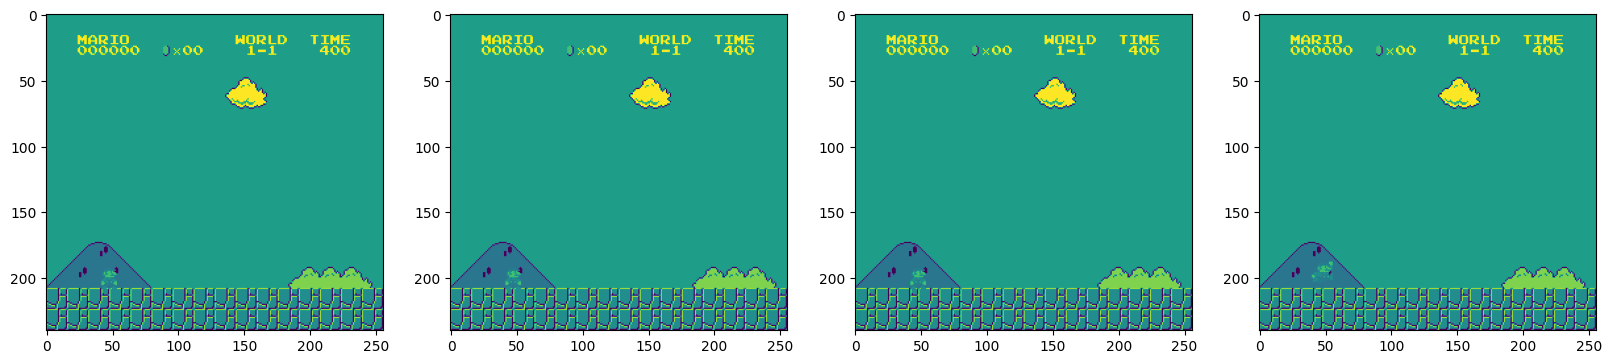

In [29]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

#### **3. Train the RL Model**

In [101]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [17]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [18]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [19]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=500000, save_path=CHECKPOINT_DIR)

In [61]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [62]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/PPO_1


c:\Users\vishv\OneDrive\Documents\AIML_2\CSCN8020_Reinforcement Learning\gym-maze\CSCN8020_rl\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 33  |
|    iterations      | 1   |
|    time_elapsed    | 15  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 2             |
|    time_elapsed         | 23            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.0093983e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.00692       |
|    learning_rate        | 1e-06         |
|    loss                 | 112           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000259     |
|    value_loss           | 342           |
-------------------------------------------
-----

#### **4. Train the Model for Further 3000000 Timestemps**

In [90]:
import numpy as np

In [47]:
# Path where your model is saved
CHECKPOINT_DIR = './trained_models/'
LOG_DIR = './logs/'

In [48]:
# Load the model saved after 1 million timesteps
model = PPO.load('./train/best_model_1000000', env=env)

Wrapping the env in a VecTransposeImage.


In [49]:
# Setup model saving callback with reward logging
callback = TrainAndLoggingCallback(check_freq=500000, save_path=CHECKPOINT_DIR)

In [50]:
# Continue training the model, aiming for a total of 4 million timesteps
model.learn(total_timesteps=3000000, callback=callback)

Logging to ./logs/PPO_4
----------------------------
| time/              |     |
|    fps             | 178 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 114           |
|    iterations           | 2             |
|    time_elapsed         | 8             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00040449377 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.239        |
|    explained_variance   | 0.856         |
|    learning_rate        | 1e-06         |
|    loss                 | 66.4          |
|    n_updates            | 19540         |
|    policy_gradient_loss | -0.000271     |
|    value_loss           | 178           |
-------------------------

In [51]:
model.save('./trained_models/final_model_4000000')

#### **4. Test it Out**

In [115]:
# Load model
model = PPO.load('./trained_models/final_model_4000000')

In [103]:
state = env.reset()

In [ ]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

    if done:
        state = env.reset()